# Automated Tracking of monomers in a chain

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob, os
from rayleighsommerfeld02 import rayleighsommerfeld
from numpy import diff
import pandas as pd
from findpeaks import findpeaks
import pprint
import trackpy as tp

In [2]:
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg

app = QApplication.instance() or QApplication([])

### final saved trajectories (n particles for T total time steps) will be a dictionary like this:

### {0: [(x_1, y_1, z_1), (x_2,y_2,z_2),... (x_n,y_n,z_n)], 
### 1: [(x_1, y_1, z_1), (x_2,y_2,z_2),... (x_n,y_n,z_n)], 
### ... , 
### T-1: [(x_1, y_1, z_1), (x_2,y_2,z_2),... (x_n,y_n,z_n)]}

In [41]:
save_data = np.load('trajectories.npy', allow_pickle = True).item()

### get foreground images of video

In [89]:
filelist = glob.glob("./060922/*.avi")
print(filelist[16])
vidcap = cv2.VideoCapture(filelist[16])
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        t = str(count).zfill(4)
        cv2.imwrite(filelist[16][:-4] + "/fg_image_"+t+".png", image)
    return hasFrames
sec = 0
frameRate = 1/30
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

./060922/6-mer_500.avi


### pull up the first image from this experiment

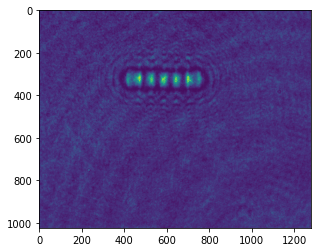

In [5]:
filelist = glob.glob("./060922/*.avi")
fg = plt.imread(filelist[16][:-4] + '/fg_image_0001.png')
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2GRAY)

plt.imshow(fg)

### crop feature to a 512x512 image

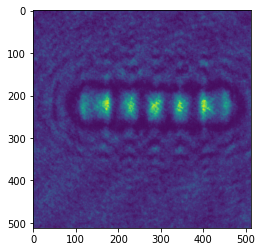

In [6]:
xmin = 300
ymin = 100
fg_cropped = fg[ymin:ymin+512, xmin: xmin+512]
plt.imshow(fg_cropped)

### run rayleigh-sommerfeld algorithm 

In [7]:
zmin = -20 #in um
zmax = 0 
n = 400
mpp = 0.048

z = np.linspace(zmin, zmax, n) / mpp #in px

last_z_list = [z for i in range(6)]

b = fg_cropped
rs = rayleighsommerfeld(b, z, magnification=mpp, nozphase=True)
bz = np.abs(rs).astype(float)
phi = np.angle(rs - 1.)

In [37]:
widget = pg.ImageView()
widget.setImage(bz.T)
widget.show()

### pull up image at focus to get $x_1^{(1)}, y_1^{(1)}, x_1^{(2)}, y_1^{(2)},$ etc (chosen manually)

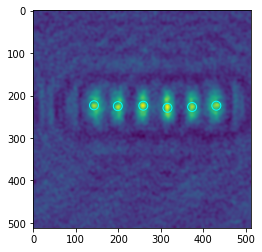

In [35]:
z_guess = 113

fig, ax = plt.subplots()
ax.imshow(bz[:,:,z_guess])

zlist = []
xlist = [143, 199, 259, 316, 374, 431]
ylist = [223, 225, 224, 229, 227, 224]

for i in range(len(xlist)):
    ax.scatter(xlist[i],ylist[i],s=80, facecolors='none', edgecolors='cyan')
plt.show()

### use a peakfinder algorithm that we may use later to automatically find monomer centers -- check viability

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 60.0.
[findpeaks] >Detect peaks using topology method with limit at 60.0.
[findpeaks] >Fin.


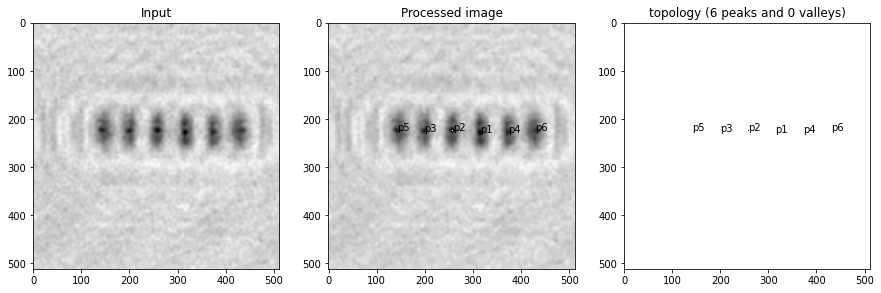

0    315
1    258
2    199
3    373
4    142
5    430
Name: x, dtype: object 0    228
1    224
2    225
3    228
4    223
5    223
Name: y, dtype: object


In [63]:
# Initialize
fp = findpeaks(method='topology', scale=True, denoise='fastnl', window=2, togray=True, limit = 60.)
# Fit
results = fp.fit(bz[:,:,z_guess])
fp.plot()
x_fit = results['persistence'].x
y_fit = results['persistence'].y
print(x_fit, y_fit)

### trackpy works too

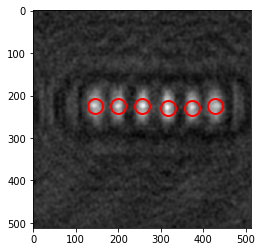

8     145.740813
9     427.817104
10    256.881058
11    200.253555
12    316.355587
13    372.925593
Name: x, dtype: float64 8     223.576973
9     225.421650
10    225.492323
11    225.404932
12    228.546543
13    229.484086
Name: y, dtype: float64


In [69]:
a = bz[:,:,z_guess]
f = tp.locate(a, 53, invert=False, minmass=20)
tp.annotate(f, a)
print(f.x, f.y)

### Compare the two methods (looks like trackpy may be more precise, but it is less accurate. Choose peakfinder)

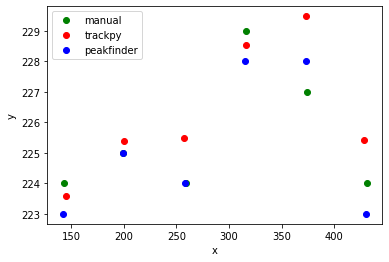

In [86]:
fig,ax = plt.subplots()
ax.plot(xlist, ylist, 'go', label = 'manual')
ax.plot(f.x, f.y, 'ro', label = 'trackpy')
ax.plot(x_fit, y_fit, 'bo', label = 'peakfinder')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

### just a thought: we know the distance r between monomers, and can search for neighbors by tracing a half circle of known radius

In [ ]:
def get_int(A, xc, yc, r): #given some center (xc,yc), what are the intensity values obtained some radius away in an array A?
    n = 100
    max_so_far = 0.
    theta_list = np.linspace(-np.pi,np.pi,n)
    for theta in theta_list:
        x = xc+r*np.cos(theta)
        y = yc+r*np.sin(theta)
        if A[int(y), int(x)] > max_so_far:
            max_so_far = A[int(y), int(x)]
            xmax = x
            ymax = y
    print([x,y])
    return [x,y]
    
get_int(b, xlist[4], ylist[4], 60)

### get $z_p$ predictions for first frame

guess from intensity -15.600
z_p =  -14.85 with L_0 = 103


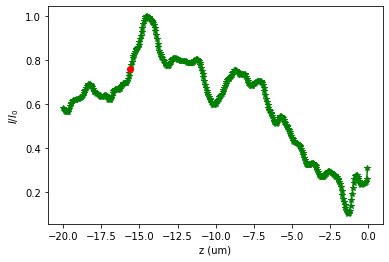

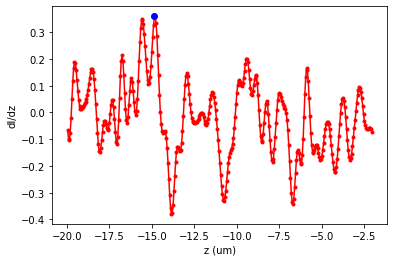

In [45]:
#particle n
index = 2

Y = []
z = []

n = 400
for i in np.linspace(0, n-1, n):
    i = int(i)
    z.append((zmin + i/n * (zmax - zmin))) #in um
    Y.append(bz[ylist[index],xlist[index],i])

Y = [y/np.max(Y) for y in Y]    
plt.ylabel(r'$I/I_0$')
plt.xlabel('z (um)')
plt.plot(z,Y,'g*-')

max_Y = np.max(Y)
thresh = 0.25 #within 30% of max values
indexes = [count for count, el in enumerate(Y) if (max_Y-el)/max_Y < thresh]
z_f = z[indexes[0]]
print('guess from intensity', format(z_f, ".3f")) #in um

_=plt.plot(z_f, Y[indexes[0]], 'ro')

#############################################################################
fig, ax = plt.subplots()

dx = 1*(zmax - zmin) / n #in um
dy = diff(Y)/dx #Y is the intensity
dy = dy[:len(dy)-40] #avoid potential z=0 singularity

sorted_dy = dy.copy()
sorted_dy.sort()
max_val = sorted_dy[-1]#change to -1 if no singularity at center

L = [i for i in range(len(dy)) if dy[i]==max_val] 
print('z_p = ', z[L[0]], 'with L_0 = {}'.format(L[0]))
plt.ylabel('dI/dz')
plt.xlabel('z (um)')

plt.plot(z[1:len(z)-40],dy, 'r.-')
plt.plot(z[L[0]],dy[L[0]], 'bo')

In [49]:
zlist.append(z[L[0]])
print(zlist)

[-15.55, -15.2, -15.6, -15.15, -14.8, -15.2]


### save to dictionary

In [51]:
framenum = 0
frame = []
for i in range(len(xlist)):
    x = xlist[i]*mpp
    y = ylist[i]*mpp
    z = -zlist[i]
    frame.append((x,y,z))
save_data[framenum] = frame
print(save_data)

{0: [(6.864, 10.752, 15.55), (9.552, 10.8, 15.2), (12.432, 10.752, 15.6), (15.168000000000001, 10.992, 15.15), (17.952, 10.896, 14.8), (20.688, 10.752, 15.2)]}


### <font color='green'>Helper Function:</font> find index of closest coordinates for query  (xq, yq)

In [8]:
def get_closest_coords(xq, yq, xlist, ylist):
    dist = [(xlist[i]-xq)**2 + (ylist[i]-yq)**2 for i in range(len(xlist))]
    min_index = dist.index(min(dist))
    return min_index

In [9]:
values_to_be_interpolated = []

### now that we have initial guesses, let's try to automate the process (the whole point of all of this)

LOOKING AT PARTICLE #0
max gradient at: 102.25563909774439, corresponding z index at: 122
delta is...40
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Fin.


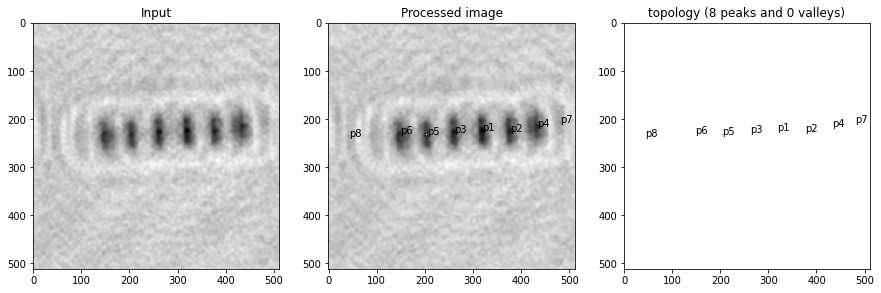

x guess: 151.0 x fit: 148 y_guess: 229.0 y_fit: delta: 4.0
310.1503759398496 295.53049289891396
LOOKING AT PARTICLE #1
max gradient at: 99.24812030075192, corresponding z index at: 119
delta is...40
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Fin.


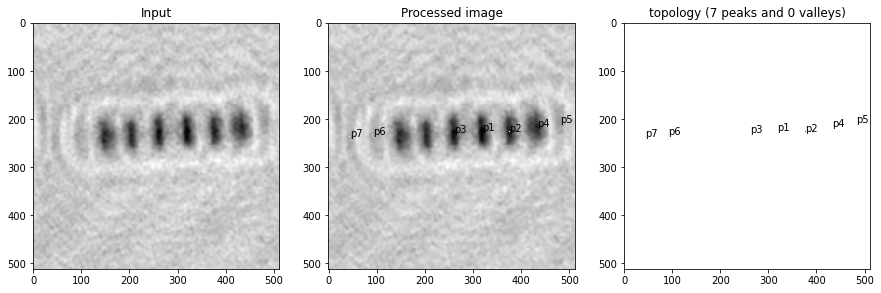

delta is...54.0
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Fin.


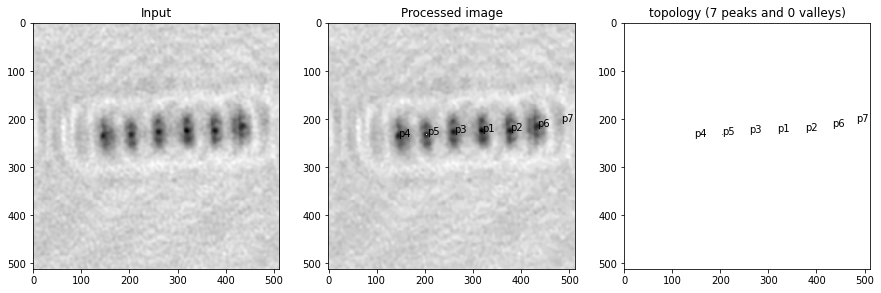

x guess: 208.0 x fit: 204 y_guess: 228.0 y_fit: delta: 9.0
313.2832080200501 301.79615705931496
LOOKING AT PARTICLE #2
max gradient at: 86.2155388471178, corresponding z index at: 106
delta is...40
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Fin.


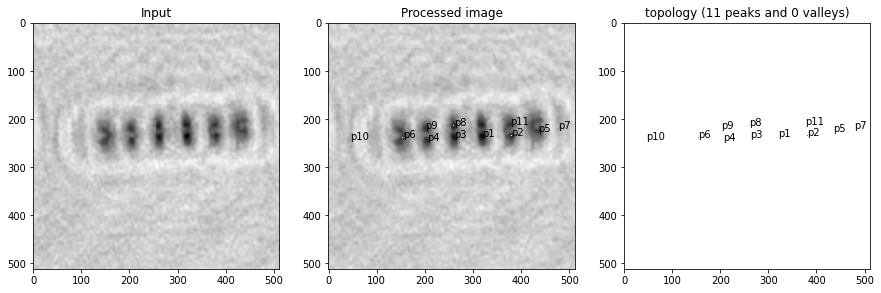

x guess: 266.0 x fit: 261 y_guess: 231.00000000000003 y_fit: delta: 11.999999999999972
326.858813700919 319.54887218045116
LOOKING AT PARTICLE #3
max gradient at: 101.2531328320802, corresponding z index at: 121
delta is...40
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Fin.


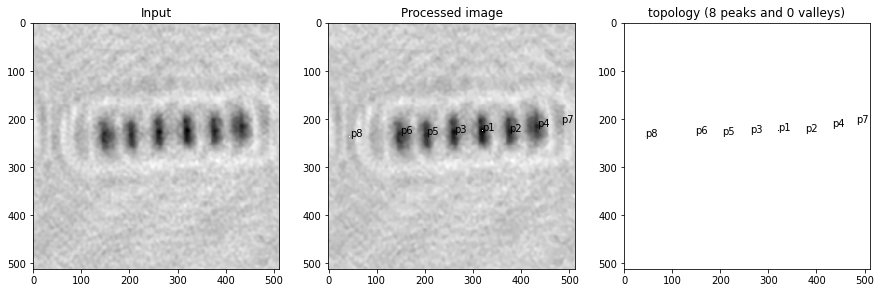

x guess: 323.0 x fit: 320 y_guess: 223.0 y_fit: delta: 4.0
311.19465329991647 292.39766081871346
LOOKING AT PARTICLE #4
max gradient at: 109.2731829573935, corresponding z index at: 128
delta is...40
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Fin.


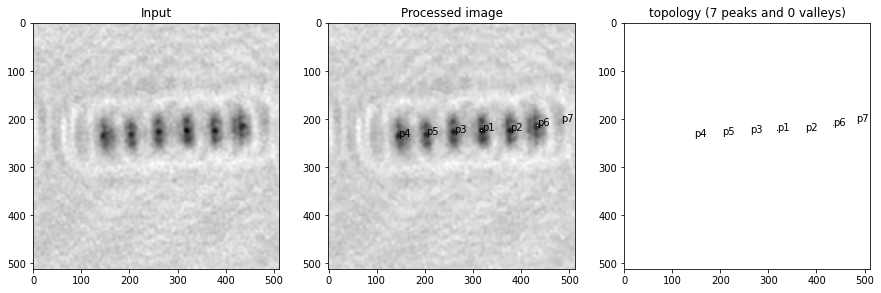

x guess: 381.0 x fit: 377 y_guess: 227.0 y_fit: delta: 7.0
302.8404344193818 291.3533834586466
LOOKING AT PARTICLE #5
max gradient at: 113.28320802005013, corresponding z index at: 132
delta is...40
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [2].
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Detect peaks using topology method with limit at 40.
[findpeaks] >Fin.


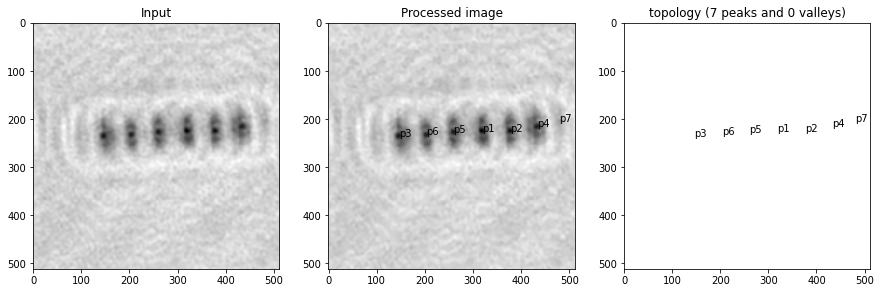

x guess: 437.0 x fit: 433 y_guess: 220.0 y_fit: delta: 8.0
298.66332497911446 280.9106098579783
[7.104, 9.792, 12.528, 15.36, 18.096, 20.784] [11.040000000000001, 11.184000000000001, 11.424, 10.752, 10.752, 10.368] [14.18546365914787, 14.48621553884712, 15.338345864661656, 14.035087719298247, 13.984962406015036, 13.483709273182958]
[(60, 2), (60, 2), (80, 2), (100, 2), (100, 3), (120, 0)]


In [37]:
framenum = 140

n = 6 #number of monomers
current_x_list = []
current_y_list = []
current_z_list = []

#get image and crop
t = str(framenum+1).zfill(4)
fg = plt.imread(filelist[16][:-4] + '/fg_image_{}.png'.format(t))
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2GRAY)
fg_cropped = fg[ymin:ymin+512, xmin: xmin+512]

for i in range(6):
    
    print("LOOKING AT PARTICLE #{}".format(i))
    
    #get initial x,y guesses in units of pixels on a 512x512 grid. convert z later
    x0 = save_data[framenum-20][i][0]/0.048
    y0 = save_data[framenum-20][i][1]/0.048
    z0 = save_data[framenum-20][i][2]
    
    #z is the range for rs. It is in pixels. Find the appropriate z index corresponding to the guess z0
    z = last_z_list[i]
    full_range = (max(z) - min(z)) #in px
    z0/=-mpp #make our guess for z negative and in px
    z_max_grad = ((z0-min(z))/full_range)*len(z)
    
    #the gradient of intensity is maximized near but not at the focus. There is a relationship between 
        #where the focus is and where the gradient is maximized. 
    z_index = round((z_max_grad + 25.4)/1.05)
    print('max gradient at: {},'.format(z_max_grad), 'corresponding z index at: {}'.format(z_index))

    #completely changed this bit. delta is the difference between y_guess and y_fit, x_guess and x_fit. If the difference is too large
        #then run the algorithm again for a different z_guess by increasing z_guess (since it is possible that it is stuck at a prior value)
    delta = 40
    while delta > 15:
        print("delta is...{}".format(delta))
        #now select the frame that corresponds to our guess for z from last frame
        b = bz[:,:,round(z_index)]
        #peakfinding:
        thresh = 40
        win = 2 
        fp = findpeaks(method='topology', scale=True, denoise='fastnl', window=win, togray=True, limit = thresh)
        results = fp.fit(b)
        fp.plot()
        k = len(results['persistence'].x)
        while k<n: #get more than just n features in case there are more prominent outliers
            thresh -= 10 #keep loosening threshold until we detect n features
            fp = findpeaks(method='topology', scale=True, denoise='fastnl', window=win, togray=True, limit = thresh)
            results = fp.fit(b)
            k = len(results['persistence'].x)
        x_fit = results['persistence'].x
        y_fit = results['persistence'].y

        #choose features that are closest to our guess
        index = get_closest_coords(x0, y0, x_fit, y_fit)
        x = x_fit[index]
        y = y_fit[index]
        
        delta = abs(y0-y)+abs(x0-x)
        z_index+=10 #move closer and closer to zero
        
    print('x guess:', x0, 'x fit:', x, 'y_guess:', y0, 'y_fit:', 'delta:', delta)
    
    #we have a guess for z0. Run rayleigh sommerfeld for a smaller range of z, centered around this guess
    z = np.linspace(zmin, zmax, 400) / mpp #in px
    rs = rayleighsommerfeld(fg_cropped, z, magnification=mpp, nozphase=True)
    bz = np.abs(rs).astype(float)
        
    #time to find z
    #since we have exact x and y values, look at intensity list at that location across different z's
    intensity_list = bz[y,x,:]
    dx = 1
    dy = diff(intensity_list)/dx
    dy = dy[:len(dy)-40] #in case there is singularly large value at z=0
    #choose z value for which gradient of intensity dI/dz is maximized, ignoring points close to 0.
    sorted_dy = dy.copy()
    sorted_dy = dy.copy()
    sorted_dy.sort()
    max_val = sorted_dy[-1]
    L = [i for i in range(len(dy)) if dy[i]==max_val] 
    zf = z[L[0]]

    #save and check if z needs to be interpolated for later
    current_x_list.append(x*0.048)
    current_y_list.append(y*0.048)
    
    print(abs(z0),abs(zf))

    if abs(z0)-abs(zf) > 20:
        zf = -abs(z0)
        print('reverting to z guess -- will need to interpolate, later: '.format(abs(zf),abs(z0)))
        values_to_be_interpolated.append((framenum, i)) #(framenum, n) pair so we can later interpolate for these values
    current_z_list.append(-zf*0.048)
        
#print all results
print(current_x_list, current_y_list, current_z_list)
print(values_to_be_interpolated)

### visualize results

Text(0, 0.5, 'z (um)')

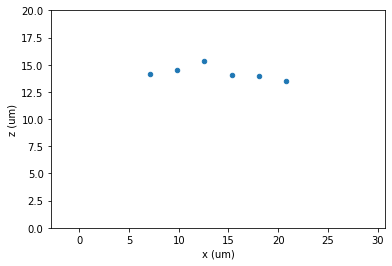

In [38]:
fig, ax = plt.subplots()
ax.scatter(current_x_list, current_z_list, s=20)
ax.set_ylim(0, 20)
ax.set_xlim(min(current_x_list)-10, max(current_x_list)+10)
ax.set_xlabel('x (um)')
ax.set_ylabel('z (um)')

### if it all looks good, save 

In [39]:
frame = []
for i in range(len(current_x_list)):
    x = current_x_list[i]
    y = current_y_list[i]
    z = current_z_list[i]
    frame.append((x,y,z))
save_data[framenum] = frame
pprint.pprint(save_data)
np.save('trajectories.npy', save_data)

{0: [(6.864, 10.752, 15.55),
     (9.552, 10.8, 15.2),
     (12.432, 10.752, 15.6),
     (15.168000000000001, 10.992, 15.15),
     (17.952, 10.896, 14.8),
     (20.688, 10.752, 15.2)],
 20: [(6.864, 10.704, 15.538847117794488),
      (9.6, 10.896, 15.037593984962404),
      (12.384, 10.704, 14.887218045112782),
      (15.120000000000001, 10.896, 14.93734335839599),
      (17.904, 10.848, 14.786967418546366),
      (20.64, 10.656, 15.238095238095235)],
 40: [(6.912, 10.752, 15.538847117794488),
      (9.552, 10.944, 14.987468671679197),
      (12.24, 10.8, 15.739348370927319),
      (15.072000000000001, 10.896, 14.987468671679197),
      (17.856, 10.752, 14.135338345864664),
      (20.688, 10.608, 14.586466165413533)],
 60: [(6.912, 10.704, 15.48872180451128),
      (9.6, 10.848, 14.48621553884712),
      (12.384, 11.136000000000001, 15.739348370927319),
      (15.120000000000001, 10.896, 14.887218045112782),
      (17.952, 10.896, 14.736842105263158),
      (20.592, 10.656, 14.48621553

### plot the whole experiment

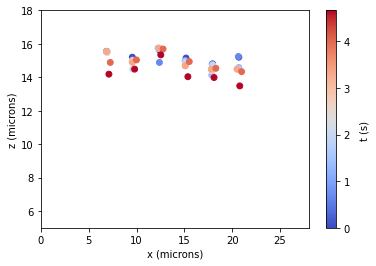

In [40]:
from matplotlib import cm
cm = plt.cm.get_cmap('coolwarm')
T = max(save_data.keys())
n = 6 #number of monomers
for t in save_data.keys():
    x = [save_data[t][i][0] for i in range(n)]
    z = [save_data[t][i][2] for i in range(n)]
    col = [t/30 for i in range(n)]
    plt.scatter(x,z, c=col, vmin=0, vmax=T/30, s=35, cmap=cm)
plt.xlabel('x (microns)')
plt.ylabel('z (microns)')
plt.ylim([5,18])
plt.xlim([0,28])
c = plt.colorbar()
c.set_label('t (s)', labelpad=10, y=0.45)
    